In [48]:
import pandas as pd
import numpy as np
import chardet

In [49]:
interest_periods = [
   ["2016-2021", "Soybeans", "China", ["IL", "IA", "MN", "IN", "NE"], "2018", 25],
   ["2016-2021", "Corn", "China", ["IA", "IL", "NE", "MN", "IN"], "2018", 25],
   ["2016-2021", "Cotton", "China", ["TX", "GA", "AR", "MS", "AL"], "2018", 25],
   ["2016-2021", "Wheat", "China", ["KS", "ND", "MT", "WA", "OK"], "2018", 25],
   ["2016-2021", "Rice", "China", ["AR", "CA", "LA", "MS", "MO"], "2018", 25],
   ["2014-2019", "Rice", "EU", ["AR", "CA", "LA", "MS", "MO"], "2015", 20],
   ["2011-2016", "Cotton", "India", ["TX", "GA", "AR", "MS", "AL"], "2012", 30]
]

interest_periods_df = pd.DataFrame(interest_periods, columns=['Period', 'Crop', 'Trade Partner', "States", "Effect Year", "Tariff Rate"])

In [78]:
interest_periods_df

,Period,Crop,Trade Partner,States,Effect Year,Tariff Rate
0,2016-2021,Soybeans,China,"[IL, IA, MN, IN, NE]",2018,25
1,2016-2021,Corn,China,"[IA, IL, NE, MN, IN]",2018,25
2,2016-2021,Cotton,China,"[TX, GA, AR, MS, AL]",2018,25
3,2016-2021,Wheat,China,"[KS, ND, MT, WA, OK]",2018,25
4,2016-2021,Rice,China,"[AR, CA, LA, MS, MO]",2018,25
5,2014-2019,Rice,EU,"[AR, CA, LA, MS, MO]",2015,20
6,2011-2016,Cotton,India,"[TX, GA, AR, MS, AL]",2012,30


In [67]:
class DataLoader():
    def __init__(self):
        self._base_path = "datasets/model1/"

        self._fx_dict = {
            "CHINA" : "CNY",
            "EU" : "EUR",
            "INDIA" : "INR",
            "MEXICO" : "MXN"
        }

    def open_csv(self, path):
        with open(path, 'rb') as file:
            raw = file.read()
            result = chardet.detect(raw)
            encoding = result['encoding']

        df = pd.read_csv(path, encoding=encoding)
        return df
    
    def load_period(self, row):
        row = list(row)
        self.years = row[0]
        self.commodity = row[1].upper()
        self.trade_parter = row[2].upper()
        self.effect_year = int(row[4])
        self.rate = int(row[5])

        commodity_path = f"{self._base_path}commodities/{self.commodity}.csv"
        self.commodity_df = self.open_csv(commodity_path)

        fx_path = f"{self._base_path}fx/USD{self._fx_dict[self.trade_parter]}.csv"
        self.fx_df = self.open_csv(fx_path)

        fas_path = f"{self._base_path}USDA_FAS/{self.years}-{self.commodity}.csv"
        self.fas_df = self.open_csv(fas_path)

        nass_path = f"{self._base_path}USDA_NASS/{self.years}-{self.commodity}.csv"
        self.nass_df = self.open_csv(nass_path)

        agr_raw_path = f"{self._base_path}AGR_Raw_Material_Price_Index.csv"
        self.agr_raw_df = self.open_csv(agr_raw_path)

        drought_path = f"{self._base_path}Drought_Index.csv"
        self.drought_df = self.open_csv(drought_path)

        fed_rate_path = f"{self._base_path}FED_FUNDS_INTEREST_RATE.csv"
        self.fed_rate_df = self.open_csv(fed_rate_path)

        food_price_path = f"{self._base_path}FOOD_PRICE_INDEX.csv"
        self.food_price_df = self.open_csv(food_price_path)

        igc_grain_oilseeds_path = f"{self._base_path}IGC_GRAIN_AND_OILSEEDS_INDEX.csv"
        self.igc_grain_oilseeds_df = self.open_csv(igc_grain_oilseeds_path)

        arms_path = f"{self._base_path}USDA_ARMS_DATAPOINTS.csv"
        self.arms_df = self.open_csv(arms_path)

    def generate_training_set(self):
        # Convert dates with proper format handling
        self.commodity_df['Date'] = pd.to_datetime(self.commodity_df['Date'], dayfirst=True)
        self.fx_df['Date'] = pd.to_datetime(self.fx_df['Date'], dayfirst=True)
        self.fas_df['Date'] = pd.to_datetime(self.fas_df['Date'])
        self.nass_df['Date'] = pd.to_datetime(self.nass_df['Date'])
        self.agr_raw_df['Date'] = pd.to_datetime(self.agr_raw_df['Date'])
        self.drought_df['Date'] = pd.to_datetime(self.drought_df['Date'], format="%Y%m%d")
        self.fed_rate_df['Date'] = pd.to_datetime(self.fed_rate_df['Date'])
        self.food_price_df['Date'] = pd.to_datetime(self.food_price_df['Date'])
        self.igc_grain_oilseeds_df['Date'] = pd.to_datetime(self.igc_grain_oilseeds_df['Date'], dayfirst=True)
        self.arms_df['Date'] = pd.to_datetime(self.arms_df['Date'], format="%Y")
        print("Indexed DateTime Columns")

        # Create date range for the period
        start_year, end_year = map(int, self.years.split('-'))
        date_range = pd.date_range(start=f'{start_year}-01-01', end=f'{end_year}-12-31', freq='D')
        
        # Initialize training set with date index
        training_set = pd.DataFrame(index=date_range)

        # Function to handle duplicate dates
        def aggregate_duplicates(df):
            if df.empty:
                return df
            return df.groupby('Date').agg({
                'Open': 'first',
                'High': 'max',
                'Low': 'min',
                'Close': 'last'
            }).sort_index()
        print("Initialised Training Set")

        # Add commodity price features (daily)
        if not self.commodity_df.empty:
            # Handle duplicate dates in commodity data
            commodity_clean = aggregate_duplicates(self.commodity_df)
            # Basic price features
            training_set['price'] = commodity_clean['Close']
            # Rolling statistics
            for window in [7, 14, 30, 90]:
                training_set[f'price_ma_{window}d'] = commodity_clean['Close'].rolling(window=window).mean()
                training_set[f'price_std_{window}d'] = commodity_clean['Close'].rolling(window=window).std()
            # Price momentum
            for window in [7, 14, 30]:
                training_set[f'price_momentum_{window}d'] = (
                    commodity_clean['Close'] - commodity_clean['Close'].shift(window)
                ) / commodity_clean['Close'].shift(window)
            # Trading range
            training_set['daily_range'] = (commodity_clean['High'] - commodity_clean['Low']) / commodity_clean['Close']

        print("Processed Commodity Data")

        # Add FX features (daily)
        if not self.fx_df.empty:
            # Handle duplicate dates in FX data
            fx_clean = aggregate_duplicates(self.fx_df)
            training_set['exchange_rate'] = fx_clean['Close']
            for window in [7, 14, 30]:
                training_set[f'fx_ma_{window}d'] = fx_clean['Close'].rolling(window=window).mean()
                training_set[f'fx_std_{window}d'] = fx_clean['Close'].rolling(window=window).std()

        print("Processed FX Data")

        # Add USDA FAS features (monthly, forward fill)
        if not self.fas_df.empty:
            # Handle duplicate dates by taking the last value
            fas_clean = self.fas_df.groupby('Date').last()
            fas_columns = ['monthlyExports', 'accumulatedExports', 'outstandingSales', 'grossNewSales']
            for col in fas_columns:
                if col in fas_clean.columns:
                    training_set[f'fas_{col}'] = fas_clean[col].reindex(date_range, method='ffill')

        print("Processed FAS Data")

        # Add USDA NASS features (annual, forward fill)
        if not self.nass_df.empty:
            # Handle duplicate dates by taking the last value
            nass_clean = self.nass_df.groupby('Date').last()
            nass_columns = ['Average_Yield', 'Average_Production']
            for col in nass_columns:
                if col in nass_clean.columns:
                    training_set[f'nass_{col}'] = nass_clean[col].reindex(date_range, method='ffill')

        print("Processed NASS Data")

        # Add market indices (daily)
        for df, name in [
            (self.agr_raw_df, 'agr_raw'),
            (self.food_price_df, 'food_price'),
            (self.igc_grain_oilseeds_df, 'grain_oilseeds')
        ]:
            if not df.empty:
                # Handle duplicate dates by taking the last value
                df_clean = df.groupby('Date').last()
                training_set[f'{name}_index'] = df_clean['Index'].reindex(date_range, method='ffill')
                # Add rolling statistics
                for window in [7, 14, 30]:
                    training_set[f'{name}_ma_{window}d'] = df_clean['Index'].rolling(window=window).mean()

            print(f"Processed {name} Data")

        if not self.drought_df.empty:
            drought_clean = self.drought_df.groupby('Date').last()
    
            # Create a DataFrame with all drought levels
            drought_features = pd.DataFrame(index=date_range)
            
            # Process each drought level
            drought_levels = ['None', 'D0', 'D1', 'D2', 'D3', 'D4']
            for level in drought_levels:
                if level in drought_clean.columns:
                    column_name = f'drought_index_{level}'
                    reindexed_series = drought_clean[level].reindex(date_range, method='ffill')
            
                    filled_series = reindexed_series.fillna(method='bfill')
                
                    drought_features[column_name] = filled_series
                
            for col in drought_features.columns:
                training_set[col] = drought_features[col]
        
        print(f"Processed Drought Data with {len(drought_features.columns)} features")

        # Add interest rate (monthly, forward fill)
        if not self.fed_rate_df.empty:
            fed_clean = self.fed_rate_df.groupby('Date').last()
            training_set['interest_rate'] = fed_clean['Value'].reindex(date_range, method='ffill')

        print(f"Processed Fed Funds Data")

        # Add ARMS features (annual, forward fill)
        if not self.arms_df.empty:
            arms_clean = self.arms_df.groupby('Date').last()
            for col in arms_clean.columns:
                if col != 'Date':
                    training_set[f'arms_{col}'] = arms_clean[col].reindex(date_range, method='ffill')

        print(f"Processed ARMS Data")

        # Add tariff features
        training_set['tariff_active'] = (training_set.index.year >= self.effect_year).astype(int)
        training_set['tariff_rate'] = training_set['tariff_active'] * self.rate
        training_set['days_from_tariff'] = (training_set.index - pd.Timestamp(f'{self.effect_year}-01-01')).days

        # Add temporal features
        training_set['month'] = training_set.index.month
        training_set['year'] = training_set.index.year
        training_set['day_of_week'] = training_set.index.dayofweek
        training_set['quarter'] = training_set.index.quarter

        return training_set

In [68]:
dl = DataLoader()

In [69]:
for key, row in interest_periods_df.iterrows():
    dl.load_period(row)
    training_set = dl.generate_training_set()

Indexed DateTime Columns
Initialised Training Set
Processed Commodity Data
Processed FX Data
Processed FAS Data
Processed NASS Data
Processed agr_raw Data
Processed food_price Data
Processed grain_oilseeds Data
Processed Drought Data with 6 features
Processed Fed Funds Data
Processed ARMS Data
Indexed DateTime Columns
Initialised Training Set
Processed Commodity Data
Processed FX Data
Processed FAS Data
Processed NASS Data
Processed agr_raw Data
Processed food_price Data
Processed grain_oilseeds Data
Processed Drought Data with 6 features
Processed Fed Funds Data
Processed ARMS Data
Indexed DateTime Columns
Initialised Training Set
Processed Commodity Data
Processed FX Data
Processed FAS Data
Processed NASS Data
Processed agr_raw Data
Processed food_price Data
Processed grain_oilseeds Data
Processed Drought Data with 6 features
Processed Fed Funds Data
Processed ARMS Data
Indexed DateTime Columns
Initialised Training Set
Processed Commodity Data
Processed FX Data
Processed FAS Data
Pro

/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version

Processed FX Data
Processed FAS Data
Processed NASS Data
Processed agr_raw Data
Processed food_price Data
Processed grain_oilseeds Data
Processed Drought Data with 6 features
Processed Fed Funds Data
Processed ARMS Data
Indexed DateTime Columns
Initialised Training Set
Processed Commodity Data
Processed FX Data
Processed FAS Data
Processed NASS Data
Processed agr_raw Data
Processed food_price Data
Processed grain_oilseeds Data
Processed Drought Data with 6 features
Processed Fed Funds Data
Processed ARMS Data
Indexed DateTime Columns
Initialised Training Set
Processed Commodity Data
Processed FX Data
Processed FAS Data
Processed NASS Data
Processed agr_raw Data
Processed food_price Data
Processed grain_oilseeds Data
Processed Drought Data with 6 features
Processed Fed Funds Data
Processed ARMS Data


/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version

In [70]:
training_set

,price,price_ma_7d,price_std_7d,price_ma_14d,price_std_14d,price_ma_30d,price_std_30d,price_ma_90d,price_std_90d,price_momentum_7d,...,arms_Total cash expenses,arms_Value of inventory change,arms_Variable expenses,tariff_active,tariff_rate,days_from_tariff,month,year,day_of_week,quarter
2011-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,481779.030303,42669.909091,377288.212121,0,0,-365,1,2011,5,1
2011-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,481779.030303,42669.909091,377288.212121,0,0,-364,1,2011,6,1
2011-01-03,142.20,143.501429,1.801901,147.026429,5.468914,138.555000,11.882745,120.048556,21.926654,-0.039968,...,481779.030303,42669.909091,377288.212121,0,0,-363,1,2011,0,1
2011-01-04,143.78,143.452857,1.786969,147.143571,5.372919,139.578000,10.894839,120.674667,21.788871,-0.002359,...,481779.030303,42669.909091,377288.212121,0,0,-362,1,2011,1,1
2011-01-05,145.20,143.372857,1.675527,147.077857,5.391993,140.438333,10.245393,121.313222,21.654236,-0.003842,...,481779.030303,42669.909091,377288.212121,0,0,-361,1,2011,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-12-27,69.74,69.984286,0.554041,70.792143,0.966144,71.512000,1.468812,69.986333,2.273421,-0.026929,...,668064.531250,-9829.612903,569138.125000,1,30,1822,12,2016,1,4
2016-12-28,69.75,69.800000,0.301220,70.623571,0.923460,71.555667,1.391788,69.942778,2.239349,-0.018159,...,668064.531250,-9829.612903,569138.125000,1,30,1823,12,2016,2,4
2016-12-29,70.50,69.932857,0.378141,70.557857,0.894712,71.609000,1.315054,69.883222,2.149692,0.013368,...,668064.531250,-9829.612903,569138.125000,1,30,1824,12,2016,3,4
2016-12-30,70.65,70.120000,0.359537,70.547143,0.892485,71.607667,1.316038,69.816667,2.027397,0.018892,...,668064.531250,-9829.612903,569138.125000,1,30,1825,12,2016,4,4


In [71]:
row = interest_periods_df.iloc[0]
dl.load_period(row)
training_set = dl.generate_training_set()

Indexed DateTime Columns
Initialised Training Set
Processed Commodity Data
Processed FX Data
Processed FAS Data
Processed NASS Data
Processed agr_raw Data
Processed food_price Data
Processed grain_oilseeds Data
Processed Drought Data with 6 features
Processed Fed Funds Data
Processed ARMS Data


/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  filled_series = reindexed_series.fillna(method='bfill')
/var/folders/yy/rxmvf4s17q7bwv5swgznj8yr0000gn/T/ipykernel_33828/2076882154.py:174: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version

In [72]:
print(training_set.columns)

Index(['price', 'price_ma_7d', 'price_std_7d', 'price_ma_14d', 'price_std_14d',
       'price_ma_30d', 'price_std_30d', 'price_ma_90d', 'price_std_90d',
       'price_momentum_7d', 'price_momentum_14d', 'price_momentum_30d',
       'daily_range', 'exchange_rate', 'fx_ma_7d', 'fx_std_7d', 'fx_ma_14d',
       'fx_std_14d', 'fx_ma_30d', 'fx_std_30d', 'fas_accumulatedExports',
       'fas_outstandingSales', 'fas_grossNewSales', 'nass_Average_Yield',
       'nass_Average_Production', 'agr_raw_index', 'agr_raw_ma_7d',
       'agr_raw_ma_14d', 'agr_raw_ma_30d', 'food_price_index',
       'food_price_ma_7d', 'food_price_ma_14d', 'food_price_ma_30d',
       'grain_oilseeds_index', 'grain_oilseeds_ma_7d', 'grain_oilseeds_ma_14d',
       'grain_oilseeds_ma_30d', 'drought_index_None', 'drought_index_D0',
       'drought_index_D1', 'drought_index_D2', 'drought_index_D3',
       'drought_index_D4', 'interest_rate', 'arms_Crop sales',
       'arms_Fertilizer and chemicals', 'arms_Gross cash farm inco

<Axes: >

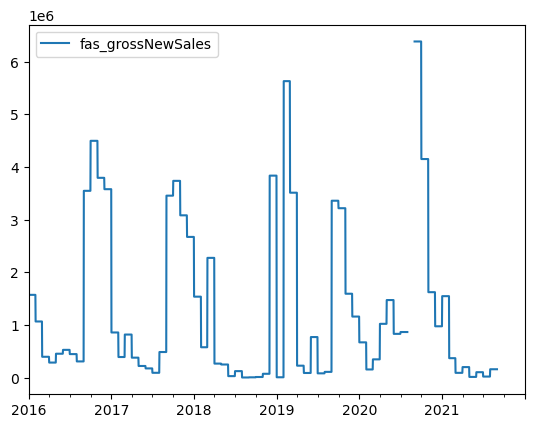

In [80]:
training_set.plot(y="fas_grossNewSales")